## 문제 사항
* 가끔 인식 부정확 - save_img/*_difficult.* 참조 - 거리 threshold 늘려서 다소 개선, 해결은 안됨
* 가운데 구획 필요할 수 있음 - 대응 전략

* 이동 후 오프셋에 따라 동작 불가능해지는 상황 발생 - 미묘한 싱귤러리티 등이 원인
* 오른 쪽 view 자꾸 겨드랑이로 - 자세 약간 수정함, 너무 돌지 않도록 추가 수정 요망
* 작업 너비 너무 좁음 - 더 확실한 영역 데이터셋 준비 필요
* 동작 비효율적 - 우선 task space 경로 만들어보고 planning 하기
* 툴 형상 변경 - 깊이 5cm 정도만 줄이자 에 따라 데이터 다시 수집 필요
* 반대편 이동 정상 동작 안됨

In [1]:
import os
import sys
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *


CONNECT_INDY = True

ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.7
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.102


In [3]:
sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP, specs={"no_sdk":True})]
              , connection_list=[CONNECT_INDY])

connection command:
indy0: True
Connect: Server IP (192.168.0.3)


In [4]:
# Directory setting
DEMO_DIR = os.path.join(RNB_PLANNING_DIR, "src/scripts/demo_202107")
CONFIG_DIR = os.path.join(DEMO_DIR, "configs")
SAVE_DIR = os.path.join(DEMO_DIR, "save_img")
CROP_DIR = os.path.join(DEMO_DIR, "crop_img")
MODEL_DIR = os.path.join(DEMO_DIR, "model_CAD")

# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734

In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# # deprecated: s_builder.reset_reference_coord(ref_name="floor")

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,np.pi))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [7]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


In [8]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary( -1.5, 1.5, -1, 1, -0.1, 1.75)

Please create a subscriber to the marker
   Use a production WSGI server instead.
 * Debug mode: off


## add env

In [9]:

# geometry 추가
mobile_base = gscene.create_safe(gtype=GEOTYPE.BOX, name="mobile_base", link_name="base_link", 
                   dims=(0.6,0.4,0.439), center=(0,0,-0.439/2), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
floor = gscene.create_safe(gtype=GEOTYPE.BOX, name="floor", link_name="base_link", 
                   dims=(10,10,0.01), center=(0,0,-0.439), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## add cam

In [10]:
for gtem in gscene:
    round_it_str(gtem.dims)
    round_it_str(gtem.center)

In [11]:
from pkg.geometry.geotype import GEOTYPE
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name="indy0_tcp", 
                   dims=(0.061,0.061,0.026), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name="indy0_tcp", 
                   dims=(0.081,0.081,0.046), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name="indy0_tcp", 
                   dims=(0.01,0.01,0.01), center=(0,0,0), rpy=(0,0,-np.pi/2), 
                   color=(1,0,0,0.3), display=True, fixed=True, collision=False, parent="cam")

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.0335), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.0535), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.067), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.087), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

In [12]:
gscene.update_markers_all()

## add indy tool

In [13]:
gscene = gscene
robot_name="indy0"
face_name="brush_face"

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.09, 0.09, 0.005), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.13, 0.13, 0.005), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.022, 0.036, 0.025), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.062, 0.076, 0.025), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.011, 0.020, 0.15), rpy=(0, 1*pi/4, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.051, 0.060, 0.15), rpy=(0, 1*pi/4, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.036, 0.022), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.076, 0.062), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.2085,0,0.121), dims=(0.08, 0.08, 0.015), rpy=(0, pi/2, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.2085,0,0.121), dims=(0.12, 0.12, 0.015), rpy=(0, pi/2, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name=face_name, link_name="{}_tcp".format(robot_name),
                   center=(0.227,0,0.121), dims=(0.037, 0.10, 0.34), rpy=(np.pi, 0, pi), color=(1.0, 1.0, 0.94, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_col".format(face_name), link_name="{}_tcp".format(robot_name),
                   center=(0.207,0,0.121), dims=(0.057, 0.10, 0.36), rpy=(np.pi, 0, pi), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

## Register binders

In [14]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(-gscene.NAME_DICT['brush_face'].dims[0]/2,0,0), 
                     rpy=(0,np.pi/2*1,0))

## Set planner

In [15]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
tcheck = TaskClearanceChecker(pscene, gcheck)
checkers_all = [tcheck, rcheck, gcheck]
# lcheck = LatticedChecker(pscene, gcheck)
# checkers_all.append(lcheck)

mplan.motion_filters = checkers_all

## move indy to viewing pose

In [16]:
indy = crob.robot_dict["indy0"]
# if indy is not None:
#     with indy:
#         indy.reset_robot()

In [17]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., -180])
if indy is not None:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

Connect: Server IP (192.168.0.3)
Move finished!


## Get image

In [18]:
rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)

In [20]:
rdict = stream_capture_image(ImageType.FirstView, host=CAM_HOST)
cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]


== press s to save image ==


In [21]:
import SharedArray as sa
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

IMG_URI = "shm://color_img"
MASK_URI = "shm://mask_img"
REQ_URI = "shm://request"
RESP_URI = "shm://response"

color_img_p = sa.attach(IMG_URI)
return_img_p = sa.attach(MASK_URI)
request_p = sa.attach(REQ_URI)
resp_p = sa.attach(RESP_URI)

def detect_from_server(image):
    color_img_p[:] = image[:]
    request_p[:] = 1
    while not resp_p[0]:
        time.sleep(0.01)
    resp_p[:] = 0
    return np.copy(return_img_p.astype(np.bool))

In [22]:
# Set color, depth image path
if indy is None:
    color_img_path = DATASET_DIR + '/color.jpg'
    depth_img_path = DATASET_DIR + '/depth.png'
else:
    color_img_path = SAVE_DIR + '/color.jpg'
    depth_img_path = SAVE_DIR + '/depth.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

In [23]:
# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

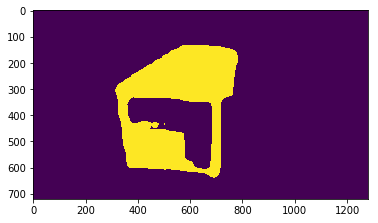

In [24]:
plt.imshow(mask_out)

In [25]:
# Crop masking part
vis_mask = (mask_out * 255).astype('uint8')
color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)

True

In [26]:
from demo_utils.detect_table import *

In [27]:
set_cam_params(cam_intrins, d_scale)
model_mesh, pcd_out = preprocessing()
ICP_result1 = compute_ICP(model_mesh, pcd_out, (-T_Height, -T_Depth, 0.0))
#ICP_result2 = compute_ICP(model_mesh, pcd2)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.118455e-03, and correspondence_set size of 81870
Access transformation to get result.
Transformation is:
[[ 0.97952723  0.00354742  0.20128047 -0.63449415]
 [ 0.08693341  0.89435887 -0.43882204 -0.18267728]
 [-0.18157366  0.44733614  0.87574048  1.77040063]
 [ 0.          0.          0.          1.        ]]


In [28]:
gscene.show_pose(VIEW_POSE)
viewpoint.draw_traj_coords([VIEW_POSE])

[array([[ 1.63500920e-11, -4.06736601e-01,  9.13545473e-01,
          3.34365761e-01],
        [-1.00000000e+00, -3.51531197e-12,  1.63322856e-11,
          1.86499992e-01],
        [-3.43154104e-12, -9.13545473e-01, -4.06736601e-01,
          8.61139862e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [29]:
from pkg.utils.rotation_utils import *
TABLE_DIMS = np.array((0.785,1.80,0.735))
OFF_DIR = np.array([1,1,-1])
# OFF_DIR = np.array([1,1,0])
#TABLE_DIMS[[0,1,2]]
#np.hstack([TABLE_DIMS[[0,1]], [0]])
T_toff = SE3(Rot_axis(3,np.pi), np.divide(TABLE_DIMS[[0,1,2]]*OFF_DIR,2))
T_co = np.matmul(np.matmul(ICP_result1, SE3(Rot_axis(1, np.pi/2), [0]*3)), T_toff)
T_lo = np.matmul(viewpoint.Toff, T_co)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo=np.matmul(T_bc, T_co)

In [30]:
# fit to plane
floor_g = gscene.NAME_DICT["floor"]
floor_height = floor_g.center[2] + floor_g.dims[2]/2

# Floor Fitting
T_bo[2,3] =  floor_height+TABLE_DIMS[2]/2

# Depth scaling
# T_bfcenter = SE3(np.identity(3), [0,0,floor_height+TABLE_DIMS[2]/2])
# T_fc = np.matmul(SE3_inv(T_bfcenter), T_bc)
# T_fo = np.matmul(SE3_inv(T_bfcenter), T_bo)
# dz_cam = T_fc[2,3]
# dz_obj = -T_fo[2,3]
# dz_co = dz_cam + dz_obj
# depth_newscale = dz_cam/dz_co
# T_co_new = T_co.copy()
# T_co_new[:3,3] *= depth_newscale
# T_bo_new = np.matmul(T_bc, T_co_new)
# T_co = T_co_new
# T_bo = T_bo_new

azimuth, zenith = mat2hori(T_bo[:3,:3])
zenith_up = np.pi-zenith
Raz = Rot_axis(3, azimuth)
Rzn = Rot_axis(2, -zenith_up)
Roff = np.matmul(np.matmul(Raz, Rzn), Raz.transpose())
T_bo[:3,:3] = np.matmul(Roff, T_bo[:3,:3])

gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry 추가
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

# Table size

In [31]:
TABLE_HEIGHT = floor_height+TABLE_DIMS[2]-0.005
TABLE_DEPTH = TABLE_DIMS[0]
TABLE_WIDTH = TABLE_DIMS[1]
TOOL_DIM = [0.32, 0.08]

## select task area

In [32]:
from demo_utils.area_select import *

In [33]:
corner_center, area_width, area_depth, height_goal, num_width, num_depth = \
    select_area(TABLE_HEIGHT, TABLE_DEPTH, TABLE_WIDTH)

0.25
area_corner1: [0.88, -0.04]
area_corner2: [0.68, 0.52]


## Add table on relative target location

In [34]:
for i_cn in range(4):
    cn_cur = CornerRev[i_cn]
    raise(NotImplementedError("copy loop to here"))

NotImplementedError: copy loop to here

In [88]:
cn_cur = CornerRev[2]
print("== Current workspace section: {}".format(cn_cur.name))

== Current workspace section: BackLeft


In [89]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (abs(area_depth),(area_width),0.01), 
                           tuple(corner_center)+(TABLE_HEIGHT,), rpy=(0,0,0), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

In [90]:
gscene.update_markers_all()

In [91]:
t_corner = np.divide(table.dims, 2)
f_corner = np.divide(track.dims, 2)

In [92]:
T_tc = SE3(corner_orientations[cn_cur], t_corner*corner_point_dirs[cn_cur])
T_fc = SE3(corner_orientations[cn_cur], f_corner*corner_point_dirs[cn_cur])
T_ft = np.matmul(T_fc, SE3_inv(T_tc))
T_bf = track.Toff
T_bt = np.matmul(T_bf, T_ft)
T_tb = SE3_inv(T_bt)

In [93]:
## 6 DoF pose to go
T_bb2 = np.matmul(table.Toff, T_tb)
gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])

In [94]:
T_mb = SE3(Rot_axis(3, 0), [0.172, 0, 0.439])

In [95]:
T_bm = SE3_inv(T_mb)
T_mm2 = np.matmul(SE3_inv(T_bm), np.matmul(T_bb2, SE3_inv(T_mb)))
T_bm2 = np.matmul(T_bm, T_mm2)
gscene.add_highlight_axis("target", "mobile", "base_link", T_bm2[:3,3], T_bm2[:3,:3])

In [96]:
# gscene.clear_highlight()

In [97]:
# get_relative mobile pose
xy_rel = T_mm2[:2,3]
quat_rel = Rotation.from_dcm(T_mm2[:3, :3]).as_quat()
quat_zw_rel = quat_rel[-2:]
xyzw_rel = np.concatenate([xy_rel, quat_zw_rel])

In [98]:
cur_xyzw = get_xyzw_cur()

In [99]:
T_approach = SE3(np.identity(3), [-0.4,0,0])
T_am_cur = T_xyzquat((cur_xyzw[:2]+(0,), (0,0)+cur_xyzw[2:]))
T_am_to = np.matmul(T_am_cur, T_mm2)
T_am_to_ready = np.matmul(T_am_to, T_approach)

tar_xy = T_am_to[:2,3].tolist()
tar_qzw = Rotation.from_dcm(T_am_to[:3,:3]).as_quat()[-2:].tolist()

tar_xy_rd = T_am_to_ready[:2,3].tolist()
tar_qzw_rd = Rotation.from_dcm(T_am_to_ready[:3,:3]).as_quat()[-2:].tolist()

In [100]:
tar_xyzw = tar_xy+tar_qzw
tar_xyzw_rd = tar_xy_rd+tar_qzw_rd
# raise(NotImplementedError("tar_xyzw: relative? absolute?"))
print("curre  xyzw: {}".format(np.round(cur_xyzw, 2)))
print("ready  xyzw: {}".format(np.round(tar_xyzw_rd, 2)))
print("target xyzw: {}".format(np.round(tar_xyzw, 2)))

curre  xyzw: [ 2.74  4.83  1.   -0.  ]
ready  xyzw: [2.96 4.96 1.   0.  ]
target xyzw: [2.56 4.96 1.   0.  ]


```
curre  xyzw: [2.76 1.22 0.86 0.51]
ready  xyzw: [3.15 3.56 1.   0.01]
target xyzw: [2.75 3.57 1.   0.01]
```

In [75]:
delta_xyzw = np.subtract(tar_xyzw, cur_xyzw)
if (cn_cur in [Corners.FrontRight, Corners.BackRight] 
    and np.linalg.norm(delta_xyzw)<2.0
   ):
    move_steps = int(ceil(np.linalg.norm(delta_xyzw) / 0.7))
    xyzw_step = delta_xyzw/move_steps
    for i_stp in range(move_steps):
        if i_stp == move_steps-1:
            tar_cur = tar_xyzw
        else:
            tar_cur = np.add(cur_xyzw, xyzw_step*(i_stp+1))
        cur_xyzw = send_pose_wait(sock_mobile, 
                                  tar_cur, 
                                  send_ip=MOBILE_IP)
else:
    cur_xyzw = send_pose_wait(sock_mobile, tar_xyzw_rd, send_ip=MOBILE_IP)
    cur_xyzw = send_pose_wait(sock_mobile, tar_xyzw, send_ip=MOBILE_IP)    
    
# # Go view loc
# cur_xyzw = send_pose_wait(sock_mobile, [2.77, 1.,   0.86, 0.51], send_ip=MOBILE_IP)

(2.7775436639785767, 4.2079758644104, 0.9997902091960714, 0.015633416914434647)
(2.8030147552490234, 4.864048004150391, 0.9995832794150921, 0.028866373408692907)


In [76]:
# # Go view loc
# cur_xyzw = send_pose_wait(sock_mobile, [2.77, 1.,   0.86, 0.51], send_ip=MOBILE_IP)

In [77]:
## add moved table in front of robot
table_front = gscene.create_safe(GEOTYPE.BOX, "table_front", "base_link", 
                                 dims=table.dims, 
                                 center=T_bt[:3,3], 
                                 rpy=Rot2rpy(T_bt[:3,:3]),
                                 color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)

table.color = (0.8,0.8,0.8,0.0)
gscene.update_markers_all()

corner_center_rel = np.abs(np.subtract(tuple(corner_center)+(TABLE_HEIGHT,), table_front.center))

### calc gaze pose

In [78]:
if indy is not None:
    with indy:
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE

Connect: Server IP (192.168.0.3)


In [79]:
GAZE_DIST = 0.5

T_bc = np.matmul(T_bt, T_tc)

if cn_cur in [Corners.FrontLeft, Corners.BackLeft]:
    T_cam_c = SE3(Rot_rpy((0,-np.pi*3/4,np.pi/2)) , (0,0,GAZE_DIST))
elif cn_cur in [Corners.FrontRight, Corners.BackRight]:
    T_cam_c = SE3(Rot_rpy((0,-np.pi*7/8,np.pi/2)) , (0,0,GAZE_DIST))
T_bcam = np.matmul(T_bc, SE3_inv(T_cam_c))
T_ecam = viewpoint.Toff
T_be = np.matmul(T_bcam, SE3_inv(T_ecam))
gscene.add_highlight_axis("cam", "effector", "base_link", T_be[:3, 3], T_be[:3,:3])
gase_traj, success = mplan.planner.plan_py("indy0", "indy0_tcp", np.concatenate(T2xyzquat(T_be)), "base_link", Qcur)

print("GAZE: {}".format(success))
if success:
    gscene.show_motion(gase_traj)
    gase_pose = gase_traj[-1]

GAZE: True


## Move to gaze pose

In [80]:
if indy is not None:
    indy.move_joint_wp(gase_traj, None, None, None)

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!


In [54]:
# ## return from gaze pose
# if indy is not None:
#     indy.move_joint_wp(np.array(list(reversed(gase_traj))), None, None, None)

## Refine plane

In [81]:
# 모서리부분 근접 촬영
rdict = stream_capture_image(ImageType.CloseView, host=CAM_HOST)
set_cam_params(rdict['intrins'], rdict['depth_scale'])

== press s to save image ==


In [82]:
if indy is None:
    img_path = DATASET_DIR + "/table_11.png"
    Qcur = np.load(DATASET_DIR + '/tablepose_11.npy')
else:
    img_path = SAVE_DIR + '/table.png'
    with indy:
        Qcur = indy.get_qcur()

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)


In [85]:
np.save(SAVE_DIR+"/Qcur_table_right.npy", Qcur)

In [83]:
from demo_utils.detect_table import *

Coeffs of eq of fitting plane are :
(-0.0014536791633170416, 0.35988023615048087, 0.9329973753688509, -0.47384914503032216)
0.45384939899432164
0.4542732629239302
0.45384939899432164
0.4542732629239302


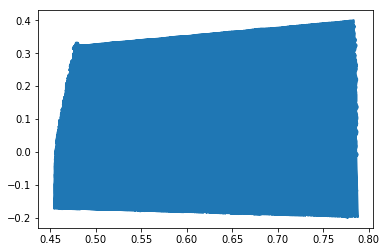

In [84]:
p_inliers = get_inliers(img_path)

T_bc = viewpoint.get_tf(list2dict(Qcur, gscene.joint_names))
viewpoint.draw_traj_coords([Qcur])
x_bo, y_bo = point_proj(T_bc, p_inliers)

from pkg.utils.rotation_utils import *
if cn_cur in [Corners.BackLeft, Corners.FrontLeft]:
    T_bo = left_corner(x_bo, y_bo)
elif cn_cur in [Corners.BackRight, Corners.FrontRight]:
    T_bo = right_corner(x_bo, y_bo)

TABLE_DIMS = np.array((0.785,1.80,0.735))
TABLE_DIMS[[0,1,2]]
gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table_front", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## move track

In [86]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (abs(area_depth),abs(area_width),0.01), 
                           corner_center_rel*corner_point_dirs[cn_cur], 
                           rpy=Rot2rpy(corner_orientations[cn_cur]), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True,
                           parent="table_front")
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

## make work plane

In [87]:
from pkg.planning.task.custom_rules.coverage import *

TOOL_DIM = [0.32, 0.08]
TACK_WIDTH = 0.36
TRACK_NUM = np.ceil(np.divide(TRACK_DIM[0]-TOOL_DIM[0], TOOL_DIM[0])).astype(np.int)+1
TRACK_STEP = TRACK_DIM[0]/TRACK_NUM

img = grayscale("scripts/demo_202107/input.jpg")

table_X = TRACK_DIM[0]
table_Y = TRACK_DIM[1]
table_x = img.shape[0]
table_y = img.shape[1]

path_gap_real = TRACK_STEP
path_gap_img = int(path_gap_real * (table_x / table_X))
wp1_pos_img, wp2_pos_img = make_waypoint(img, path_gap_img)

wp1_pos_real = np.empty([TRACK_NUM,3])
wp1_pos_real[:,0] = wp1_pos_img[:,0] * (table_X / table_x)
wp1_pos_real[:,1] = wp1_pos_img[:,1] * (table_Y / table_y)
wp1_pos_real[:,1] = -wp1_pos_real[:,1];
wp1_pos_real[:,2] = 0

wp2_pos_real = np.empty([TRACK_NUM,3])
wp2_pos_real[:,0] = wp2_pos_img[:,0] * (table_X / table_x)
wp2_pos_real[:,1] = wp2_pos_img[:,1] * (table_Y / table_y)
wp2_pos_real[:,1] = -wp2_pos_real[:,1];
wp2_pos_real[:,2] = 0

wp1_pos_real[:,0] -= TRACK_DIM[0]/2
wp1_pos_real[:,1] +=  TRACK_DIM[1]/2
wp2_pos_real[:,0] -= TRACK_DIM[0]/2
wp2_pos_real[:,1] += TRACK_DIM[1]/2

from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame

pscene.create_binder(bname="track_face", gname="track_face", _type=PlacePlane, point=None)

TRC_THIC = TRACK_DIM[2]
track_list = []

wp1_pos_real[:,1] -= TOOL_DIM[1]/2
wp2_pos_real[:,1] += TOOL_DIM[1]/2

for i_trc in range(TRACK_NUM):
    wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp1_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
#     wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
#                              (0.4, -0.01, height_goal), rpy=(0,0,0), 
#                              color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False)
    wp2 = gscene.create_safe(GEOTYPE.BOX, "wp{}b".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp2_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    
    face = gscene.create_safe(GEOTYPE.BOX, "face{}".format(i_trc+1), "base_link", 
                              (TACK_WIDTH,TRACK_DIM[1],TRC_THIC), 
                             center=(wp1_pos_real[i_trc,:]+wp2_pos_real[i_trc,:])/2,rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    track_list.append((wp1, wp2, face))
gscene.update_markers_all()

for sname in pscene.subject_name_list:
    pscene.remove_subject(sname)
    
sweep_list = []
for i_t, track_tem in enumerate(track_list):
    wp1, wp2, face = track_tem
    sweep_ = pscene.create_subject(oname="sweep{}".format(i_t+1), gname="track_face", _type=SweepLineTask, 
                                   action_points_dict = {wp1.name: SweepFrame(wp1.name, wp1, [0,0,0.005], [0,0,0]),
                                                       wp2.name: SweepFrame(wp2.name, wp2, [0,0,0.005], [0,0,0])}, 
                                   clearance=[face])
    sweep_list.append(sweep_)

In [70]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
# initial_state = pscene.initialize_state(crob.home_pose)
initial_state = pscene.initialize_state(VIEW_POSE)
print(initial_state.node)

# # remove place points except for the current one
# use_current_place_point_only(pscene, initial_state)

(0, 0)


In [71]:
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()
tplan.prepare()
mplan.update_gscene()
    
print(initial_state.node)

gtimer.tic("firstmove")
obj_num = 0
sweep_num = len(sweep_list)
from_state = initial_state.copy(pscene)
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
    gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=10, multiprocess=True, timeout=1, timeout_constrained=2, add_homing=True, post_optimize=False)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules(False)
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    snode_schedule_ori = snode_schedule
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
#     snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 5, 1)
#     double_sweep_motions(snode_schedule_safe)
#     snode_schedule = snode_schedule_safe
#     snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    snode_schedule = snode_schedule_simple
    from_state = snode_schedule[-1].state
    if t_exe:
        t_exe.join()
    else:
        if len(snode_schedule_all)==0:
            gtimer.toc("firstmove")
    snode_schedule_all.append(snode_schedule)
#     t_exe = Thread(target=ppline.play_schedule, args = (snode_schedule,), kwargs=dict( period=0.01))
#     t_exe.start()
# t_exe.join()

(0, 0)
Use 36/36 agents
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(0, 1)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
transition motion tried: True
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
try: 1 - (0, 1)->(0, 2)
try transition motion
branching: 0->1 (0.13/10.0 s, steps/err: 34(55.5250644684 ms)/0.00175284383041)
result: 0 - (0, 0)->(1, 0) = success
try: 2 - (1, 0)->(2, 0)
try constrained motion
try: 2 - (1, 0)->(2, 0)
transition motion tried: True
branching: 0->2 (0.15/10.0 s, steps/err: 34(85.0751399994 ms)/0.00175089540521)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->3 (0.15/10.0 s, steps/err: 34(70.4231262207 ms)/0.00175089540521)
try: 3 - (1, 0)->(2, 0)
transition motion tried: True
try: 0 - (0, 0)->(1, 0)
try constrained motion
try constrained motion
try: 3 - (1, 0)->(2, 0)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->4 (0.17/10.

++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
constrained motion tried: True
transition motion tried: True
result: 5 - (1, 0)->(2, 0) = success
branching: 5->23 (1.13/10.0 s, steps/err: 81(816.260099411 ms)/0.00136114416942)
result: 0 - (0, 0)->(1, 0) = success
++ adding return motion to acquired answer ++
branching: 0->24 (1.15/10.0 s, steps/err: 34(108.865022659 ms)/0.00155473727781)
try: 24 - (1, 0)->(2, 0)
try constrained motion
constrained motion tried: True
======================= terminated 6: first answer acquired ===============================
result: 4 - (1, 0)->(2, 0) = success
branching: 4->28 (1.29/10.0 s, steps/err: 81(886.064052582 ms)/0.00136114416942)
++ adding return motion to acquired answer ++
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired ===============================
======================= term

result: 0 - (2, 0)->(2, 1) = success
result: 0 - (2, 0)->(2, 1) = success
======================= terminated 0: first answer acquired from other agent ===============================
Motion Plan Failure
transition motion tried: True
branching: 0->1 (1.16/10.0 s, steps/err: 34(56.4348697662 ms)/0.00175284383041)
result: 0 - (2, 0)->(2, 1) = success
result: 1 - (0, 1)->(0, 2) = fail
branching: 0->2 (1.16/10.0 s, steps/err: 34(56.8368434906 ms)/0.00175284383041)
constrained motion tried: False
try: 1 - (2, 1)->(2, 2)
branching: 0->3 (1.18/10.0 s, steps/err: 34(61.0449314117 ms)/0.00175284383041)
======================= terminated 5: first answer acquired from other agent ===============================
try: 2 - (2, 1)->(2, 2)
transition motion tried: True
try: 3 - (2, 1)->(2, 2)
try constrained motion
try constrained motion
Motion Plan Failure
constrained motion tried: False
try: 0 - (2, 0)->(2, 1)
result: 2 - (1, 0)->(2, 0) = fail
Motion Plan Failure
result: 0 - (2, 0)->(2, 1) = success


result: 9 - (0, 1)->(0, 2) = fail
======================= terminated 16: first answer acquired from other agent ===============================
try: 4 - (2, 1)->(2, 2)
======================= terminated 15: first answer acquired from other agent ===============================
try constrained motion
try: 0 - (2, 0)->(2, 1)
try transition motion
constrained motion tried: False
Motion Plan Failure
try: 4 - (2, 1)->(2, 2)
result: 10 - (0, 1)->(0, 2) = fail
try: 0 - (2, 0)->(2, 1)
try: 2 - (2, 1)->(2, 2)
======================= terminated 24: first answer acquired from other agent ===============================
try: 0 - (2, 0)->(2, 1)
try constrained motion
try transition motion
try constrained motion
transition motion tried: True
try: 0 - (2, 0)->(2, 1)
result: 0 - (2, 0)->(2, 1) = success
try transition motion
branching: 0->8 (1.61/10.0 s, steps/err: 34(67.342042923 ms)/0.00175284383041)
try transition motion
constrained motion tried: False
try: 8 - (2, 1)->(2, 2)
transition motion trie

try constrained motion
try: 21 - (2, 1)->(2, 2)
Motion Plan Failure
Motion Plan Failure
try: 7 - (2, 1)->(2, 2)
try: 3 - (2, 1)->(2, 2)
try: 3 - (2, 1)->(2, 2)
Motion Plan Failure
try: 17 - (2, 1)->(2, 2)
try constrained motion
Motion Plan Failure
result: 4 - (2, 1)->(2, 2) = fail
result: 6 - (2, 1)->(2, 2) = fail
result: 2 - (2, 1)->(2, 2) = fail
result: 4 - (2, 1)->(2, 2) = fail
try constrained motion
try: 15 - (2, 1)->(2, 2)
try constrained motion
try constrained motion
try constrained motion
try: 11 - (2, 1)->(2, 2)
try: 0 - (2, 0)->(2, 1)
try constrained motion
try: 13 - (2, 1)->(2, 2)
try constrained motion
try transition motion
try constrained motion
try: 0 - (2, 0)->(2, 1)
try: 0 - (2, 0)->(2, 1)
try transition motion
constrained motion tried: False
try: 0 - (2, 0)->(2, 1)
try transition motion
transition motion tried: True
Motion Plan Failure
result: 8 - (2, 1)->(2, 2) = fail
try transition motion
result: 0 - (2, 0)->(2, 1) = success
try: 22 - (2, 1)->(2, 2)
branching: 0->22 (

try transition motion
result: 18 - (2, 1)->(2, 2) = fail
result: 15 - (2, 1)->(2, 2) = fail
constrained motion tried: False
try transition motion
try: 36 - (2, 1)->(2, 2)
result: 0 - (2, 0)->(2, 1) = success
try: 0 - (2, 0)->(2, 1)
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
constrained motion tried: False
try transition motion
try constrained motion
try transition motion
constrained motion tried: False
Motion Plan Failure
result: 17 - (2, 1)->(2, 2) = fail
constrained motion tried: False
branching: 0->36 (5.93/10.0 s, steps/err: 34(113.265991211 ms)/0.00130572288116)
result: 13 - (2, 1)->(2, 2) = fail
Motion Plan Failure
try: 29 - (2, 1)->(2, 2)
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
transition motion tried: True
result: 0 - (2, 0)->(2, 1) = success
transition motion tried: True
result: 19 - (2, 1)->(2, 2) = fail
try: 37 - (2, 1)->(2, 2)
result: 11 - (2, 1)->(2, 2) = fail
constrained motion tried: False
try constrained motion
try: 11 - (2, 1)->(2, 2)
transition motion tried: True

transition motion tried: True
branching: 0->50 (6.74/10.0 s, steps/err: 34(120.723962784 ms)/0.0010806337165)
result: 0 - (2, 0)->(2, 1) = success
branching: 0->51 (6.77/10.0 s, steps/err: 34(116.165161133 ms)/0.00130572288116)
try: 50 - (2, 1)->(2, 2)
try constrained motion
try: 51 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
Motion Plan Failure
result: 30 - (2, 1)->(2, 2) = fail
try: 0 - (2, 0)->(2, 1)
try transition motion
constrained motion tried: False
Motion Plan Failure
result: 33 - (2, 1)->(2, 2) = fail
try: 26 - (2, 1)->(2, 2)
transition motion tried: True
try constrained motion
result: 0 - (2, 0)->(2, 1) = success
branching: 0->52 (7.31/10.0 s, steps/err: 34(124.781131744 ms)/0.00203323551221)
try: 52 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
Motion Plan Failure
result: 34 - (2, 1)->(2, 2) = fail
try: 42 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
constrained motion tried: False
Motion Plan F

try: 0 - (2, 0)->(2, 1)
transition motion tried: True
try transition motion
transition motion tried: True
constrained motion tried: False
result: 0 - (2, 0)->(2, 1) = success
constrained motion tried: False
branching: 0->65 (8.85/10.0 s, steps/err: 34(137.662172318 ms)/0.0010806337165)
constrained motion tried: False
result: 0 - (2, 0)->(2, 1) = success
transition motion tried: True
Motion Plan Failure
Motion Plan Failure
branching: 0->64 (8.86/10.0 s, steps/err: 34(120.786905289 ms)/0.00142202875585)
result: 28 - (2, 1)->(2, 2) = fail
Motion Plan Failure
try: 64 - (2, 1)->(2, 2)
result: 24 - (2, 1)->(2, 2) = fail
result: 0 - (2, 0)->(2, 1) = success
transition motion tried: True
try constrained motion
branching: 0->66 (8.9/10.0 s, steps/err: 34(105.267047882 ms)/0.00148402282184)
try: 66 - (2, 1)->(2, 2)
result: 22 - (2, 1)->(2, 2) = fail
try: 65 - (2, 1)->(2, 2)
constrained motion tried: False
try: 24 - (2, 1)->(2, 2)
try constrained motion
result: 0 - (2, 0)->(2, 1) = success
try co

IndexError: list index out of range

constrained motion tried: False
constrained motion tried: False
======================= terminated 9: max iteration time reached (1626262704/1626262693.67 s) ===============================
constrained motion tried: False
Motion Plan Failure
======================= terminated 2: max iteration time reached (1626262704/1626262693.67 s) ===============================
Motion Plan Failure
Motion Plan Failure
result: 54 - (2, 1)->(2, 2) = fail
result: 11 - (2, 1)->(2, 2) = fail
result: 59 - (2, 1)->(2, 2) = fail
======================= terminated 24: max iteration time reached (1626262704/1626262693.67 s) ===============================
======================= terminated 0: max iteration time reached (1626262704/1626262693.67 s) ===============================
======================= terminated 30: max iteration time reached (1626262704/1626262693.67 s) ===============================
constrained motion tried: False
constrained motion tried: False
constrained motion tried: False
Motion Plan

======================= terminated 35: max iteration time reached (1626262704/1626262693.67 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 68 - (2, 1)->(2, 2) = fail
======================= terminated 19: max iteration time reached (1626262704/1626262693.67 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 69 - (2, 1)->(2, 2) = fail
======================= terminated 29: max iteration time reached (1626262704/1626262693.67 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 41 - (2, 1)->(2, 2) = fail
constrained motion tried: False
======================= terminated 1: max iteration time reached (1626262705/1626262693.67 s) ===============================
Motion Plan Failure
result: 21 - (2, 1)->(2, 2) = fail
======================= terminated 31: max iteration time reached (1626262705/1626262693.67 s) ===============================
constrained motion

## Play plan

In [72]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.001)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)


## Refine sweep motion

In [73]:
from demo_utils.refine_sweep import *

In [74]:
for snode_schedule in snode_schedule_all:
    simplify_sweep(pscene, mplan, snode_schedule, len_traj=10)

In [75]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.01)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)


In [117]:
## IndyProgram maker로 Trajectory보내야 함.

## Execute plan

In [76]:
if indy is not None:
    for snode_schedule in snode_schedule_all:
        ppline.execute_schedule(snode_schedule, one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
            
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!


## Test sweep manually

In [132]:
from pkg.utils.rotation_utils import *
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.utils.utils import list2dict

def get_jacobian(gscene, gtem, Q):
    Q_dict = list2dict(Q, gscene.joint_names)
    Jac = []
    for ij, jname in enumerate(gscene.joint_names):
        joint = gscene.urdf_content.joint_map[jname]
        Tj = T_xyzrpy((joint.origin.xyz, joint.origin.rpy))
        T_link = get_tf(joint.parent, Q_dict, gscene.urdf_content)
        T_bj = np.matmul(T_link, Tj)
        zi = np.matmul(T_bj[:3, :3], joint.axis)
        T_p = gtem.get_tf(Q_dict)
        dpi = T_p[:3, 3] - T_bj[:3, 3]
        zp = np.cross(zi, dpi)
        Ji = np.concatenate([zp, zi])
        Jac.append(Ji)
    Jac = np.array(Jac).transpose()
    return Jac

for k, v in ppline.tplan.snode_dict.items():
    gscene.show_motion(snode.traj)


    SINGULARITY_CUT = 0.01
    len_traj = 100

    Qi = snode.traj[-1]
    Qidict = list2dict(Qi, gscene.joint_names)
    Ti = gtem.get_tf(Qidict)

    dP = wp2.Toff[:3,3] - wp1.Toff[:3,3]
    dPabs = np.linalg.norm(dP)
    DP = dPabs / len_traj
    DIR = np.concatenate([dP / dPabs, [0] * 3])
    Q = Qi


    singularity = False
    Traj_wipe = [Qi]

    for _ in range(len_traj):
        Jac = get_jacobian(gscene, gtem, Q)
        if np.min(np.abs(np.real(np.linalg.svd(Jac)[1]))) <= SINGULARITY_CUT:
            singularity = True
            print("singular")
#             break
        Jinv = np.linalg.inv(Jac)
        dQ = np.matmul(Jinv, np.multiply(DIR, DP))
        Q = Q + dQ
        Traj_wipe.append(Q)
        dlim = np.subtract(RobotSpecs.get_joint_limits(RobotType.indy7), Q[:, np.newaxis])
        if np.any(dlim[:, 0] > 0):
            print("min lim: {}".format(np.where(dlim[:, 0] > 0)[0]))
            break
        if np.any(dlim[:, 1] < 0):
            print("max lim: {}".format(np.where(dlim[:, 1] < 0)[0]))
            break
    #         if not mplan.validate_trajectory([Q]):
    #             print("col")
    #             break
    #         Tnew = gtem.get_tf(list2dict(Q, gscene.joint_names))
    #         if np.abs(Ti[0,3]-Tnew[0,3])>0.01:
    #             print("off")
    #             break
    gscene.show_motion(Traj_wipe)

    Traj_wipe = np.array(Traj_wipe)